In [150]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [151]:
# ! pip install pandas-profiling

# Импорт дополнительных библиотек

In [152]:
# from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova
from sklearn import preprocessing
import category_encoders as ce
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [153]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Знакомство с данными

In [154]:
path = '/kaggle/input/sf-booking/'

In [155]:
hotels_test = pd.read_csv(path + 'hotels_test.csv')
hotels_train = pd.read_csv(path + 'hotels_train.csv')
submission = pd.read_csv(path + 'submission.csv')

In [156]:
print(hotels_test.shape)
hotels_test.head(2)


(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [157]:
print(hotels_train.shape)
hotels_train.head(2)

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [158]:
print(submission.shape)
submission.head(2)

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649


In [159]:
# Для знакомства с данными воспользуюсь библиотекой ProfileReport
# profile = ProfileReport(hotels_train, title="Pandas Profiling Report")
# profile

In [160]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
hotels_train['sample'] = 1 # помечаем трейн
hotels_test['sample'] = 0 # помечаем тест
hotels_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True) # объединяем

# Исследование данных, проектирование новых признаков

In [161]:
# Поиск пропусков
skipping = hotels.isna().sum()[hotels.isna().sum().values > 0]
skipping


lat    3268
lng    3268
dtype: int64

## Обработка пропусков lat и lng

In [162]:
# Столбец с адресами по смыслу очень близок к столбцам с координатами. Поскольку числовые значения для модели подходят
# больше текстовых, буду работать с координатами. Для заполнения пропущенных координат выделю города и страны из адресов.
# Получаю все уникальные адреса с пропущенными координатами

nulls_ = hotels.isnull().any(axis = 1)
non_lat_lng = hotels[nulls_]
address_non_lat_lng = non_lat_lng['hotel_address'].value_counts()
print(f'Всего адресов: {len(address_non_lat_lng)}')
address_non_lat_lng

Всего адресов: 17


Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
4 rue de la P pini re 8th arr 75008 Paris France               290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            147
Bail n 4 6 Eixample 08010 Barcelona Spain                      146
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             93
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               61
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        57
23 Rue Damr mont 18th arr 75018 Paris France                    55
Paragonstra e 1 11 Simmering 1110 Vienna Austria                49
20 Rue De La Ga t 14th arr 75014 Paris France                 

In [163]:
# Преобразую серию в датафрейм:
address_non_lat_lng = pd.DataFrame(address_non_lat_lng).reset_index()

# Добавляю столбец с двумя последними значениями ячейки с адресом:
address_non_lat_lng['country_city'] = address_non_lat_lng['index'].apply(lambda x: x.split(' ')[-2:])

# Получаю список уникальных значений:
list_country_city = list(address_non_lat_lng['country_city'].value_counts().index)
list_country_city

[['Vienna', 'Austria'], ['Paris', 'France'], ['Barcelona', 'Spain']]

In [164]:
# Получили всего 3 города без координат. Достану их примерные координаты из основного датафрейма.
# Добавляю аналогичный столбец "country_city" в основной датафрейм
hotels['country_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2:])
slice_for_grouping = hotels[hotels['country_city'].isin(list_country_city)]
slice_for_grouping = slice_for_grouping[['lat', 'lng', 'country_city']]

# меняю тип данных на кортеж для последующей группировки
slice_for_grouping['country_city'] = slice_for_grouping['country_city'].apply(lambda x: tuple(x))
slice_group = slice_for_grouping.groupby('country_city').agg('mean') # группирую по городам, получаю их среднве координаты
slice_group

,lat,lng
country_city,,
"(Barcelona, Spain)",41.389079,2.169147
"(Paris, France)",48.863715,2.326780
"(Vienna, Austria)",48.203362,16.367234


In [165]:
# замена отсутствующих координат средними значениями для этих городов
address_non_lat_lng['country_city'] = address_non_lat_lng['country_city'].apply(lambda x: tuple(x))
address_non_lat_lng.set_index('country_city', inplace=True)

In [166]:
lat_lng = address_non_lat_lng.join(slice_group).rename(columns= {'index': 'hotel_address', 'hotel_address': 'count'}).reset_index()[['hotel_address', 'lat', 'lng']]
lat_lng.head()

,hotel_address,lat,lng
0,Bail n 4 6 Eixample 08010 Barcelona Spain,41.389079,2.169147
1,Pau Clar s 122 Eixample 08009 Barcelona Spain,41.389079,2.169147
2,Sep lveda 180 Eixample 08011 Barcelona Spain,41.389079,2.169147
3,4 rue de la P pini re 8th arr 75008 Paris France,48.863715,2.326780
4,23 Rue Damr mont 18th arr 75018 Paris France,48.863715,2.326780


In [167]:
# Делаем левое соединение таблиц, для подстановки найденных координат в основной датафрейм
hotels = hotels.merge(lat_lng, on='hotel_address', how='left')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat_x,lng_x,sample,reviewer_score,country_city,lat_y,lng_y
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,"[Milan, Italy]",NaN,NaN
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,"[Amsterdam, Netherlands]",NaN,NaN
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,"[Barcelona, Spain]",NaN,NaN


In [168]:
# Объединяем координаты, удаляем лишние столбцы.
hotels['lat'] = hotels['lat_x'].fillna(0) + hotels['lat_y'].fillna(0) # Заменяю NaN на 0 и складываю значения
hotels['lng'] = hotels['lng_x'].fillna(0) + hotels['lng_y'].fillna(0)
hotels.drop(columns= ['lat_x', 'lng_x', 'lat_y', 'lng_y'], inplace=True)
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country_city,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,"[Milan, Italy]",45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,"[Amsterdam, Netherlands]",52.385649,4.834443


## Обработка review_date

In [169]:
# Из даты может оказаться полезной информация о днях недели. Предположительно, в разные дни недели в отели могут заселяться 
# для разных целей,соответственно, иметь разные ожидания и требования к качеству. Также полезными могут оказаться номера месяцев, 
# так как в разное время года условия в отелях могут различаться.

In [170]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], dayfirst=True)
hotels['dayofweek'] = hotels['review_date'].dt.dayofweek # День недели 0-пн, 6-вс
hotels['month'] = hotels['review_date'].dt.month # Номер месяца
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country_city,lat,lng,dayofweek,month
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,"[Milan, Italy]",45.533137,9.171102,4,7
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,"[Amsterdam, Netherlands]",52.385649,4.834443,0,12


## Обработка 'reviewer_nationality'

In [171]:
# По данным о национальности рецензента можно создать признак-мигалку, является ли посетитель отеля иностранцем.

Иностранцев 336811, Не иностранцев 178927



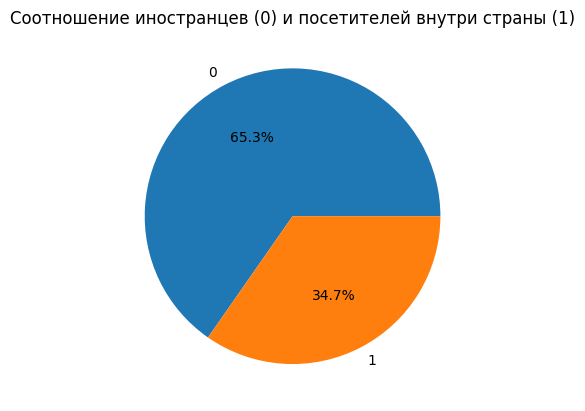

''

In [172]:
# В столбце 'reviewer_nationality' нужно срезать лишние пробелы вначале и в конце.

# Ищем национальность в адресе.
hotels['foreigner'] = hotels.apply(lambda row: 1 if row['reviewer_nationality'][1:-1] in row['hotel_address'] else 0, axis=1 )

# визуализация
data = hotels['foreigner'].value_counts()
labels = data.index
plt.pie(data, labels=labels, autopct='%.1f%%')
plt.title("Соотношение иностранцев (0) и посетителей внутри страны (1)")

print(f'Иностранцев {data[0]}, Не иностранцев {data[1]}')
print()
plt.show()
;

## Обработка отзывов

In [173]:
%%time
# Попробуем узнать эмоциональную окраску отзывов
sent_analyzer = SentimentIntensityAnalyzer()
hotels['negative_review_emo'] = hotels['negative_review'].apply(lambda string: sent_analyzer.polarity_scores(string))

CPU times: user 2min 42s, sys: 213 ms, total: 2min 42s
Wall time: 2min 42s


In [174]:
# Получил дополнительный признак со значениями в виде словаря
hotels['negative_review_emo'][0:5]

0    {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...
1    {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...
2    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
4    {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
Name: negative_review_emo, dtype: object

In [175]:
# Создаю 4 новых признака по значениям словаря
hotels['neg'] = hotels['negative_review_emo'].apply(lambda x: x['neg'])
hotels['neu'] = hotels['negative_review_emo'].apply(lambda x: x['neu'])
hotels['pos'] = hotels['negative_review_emo'].apply(lambda x: x['pos'])
hotels['compound'] = hotels['negative_review_emo'].apply(lambda x: x['compound'])

hotels.drop(columns= 'negative_review_emo', inplace=True) # удаляю "отработанный" столбец

hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,country_city,lat,lng,dayofweek,month,foreigner,neg,neu,pos,compound
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,"[Milan, Italy]",45.533137,9.171102,4,7,0,0.129,0.747,0.125,-0.0554
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,"[Amsterdam, Netherlands]",52.385649,4.834443,0,12,0,0.216,0.784,0.000,-0.2960
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,...,"[Barcelona, Spain]",41.393192,2.161520,3,11,0,0.000,1.000,0.000,0.0000


In [176]:
# Анализ негативных отзывов
df_negative = hotels[['negative_review', 'review_total_negative_word_counts']]
display(df_negative.head())
df_negative['negative_review'].value_counts()

,negative_review,review_total_negative_word_counts
0,Would have appreciated a shop in the hotel th...,52
1,No tissue paper box was present at the room,10
2,Pillows,3
3,No Negative,0
4,No Negative,0


No Negative                                                                                                                                                                                                             127890
 Nothing                                                                                                                                                                                                                 14295
 Nothing                                                                                                                                                                                                                  4236
 nothing                                                                                                                                                                                                                  2225
 N A                                                                                                        

In [177]:
# При первом осмотре видно, что количество слов комментария завышено на 2. Также есть отзывы, которые не являются негативными,
# но учитываются в подсчете слов, например, отзыв "No complaints".
# Также одинаковые слова, написанные по-разному, учитываются по отдельности

In [178]:
# Убираю пробелы вначале и в конце, привожу к нижнему регистру
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip().lower())

In [179]:
# Сравню самые популярные отзывы со средней оценкой, чтобы понять их направленность, положительные или отрицательные.
# Для такого сравнения подойдет только часть hotels_train
hotels_train = hotels[hotels['sample'] == 1]

list_top_30 = list(hotels_train['negative_review'].value_counts().head(30).index) # Выбираю топ 30 отзывов
df_no_negative = hotels_train[hotels_train['negative_review'].isin(list_top_30)]
s_no_negative = df_no_negative[['negative_review', 'reviewer_score']].groupby('negative_review').agg('mean').sort_values('reviewer_score') # Группирую по оценке
s_no_negative = s_no_negative.round(2)

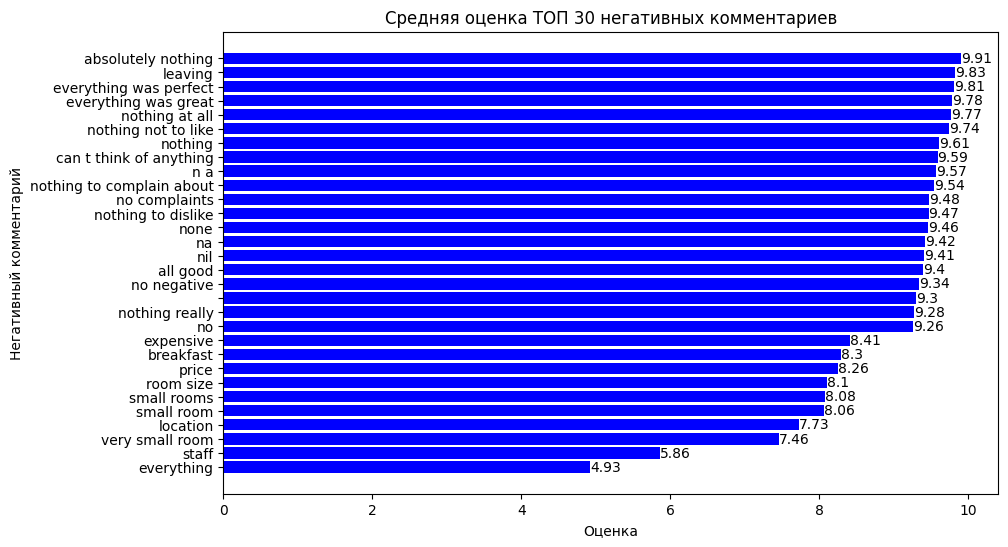

In [180]:
s = s_no_negative.reset_index()

# строим график
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(s['negative_review'], s['reviewer_score'], color='blue')

# добавляем текст на график
for i, v in enumerate(s['reviewer_score']):
    ax.text(v, i, str(v), ha='left', va='center')

# задаем заголовок и метки осей
ax.set_title('Средняя оценка ТОП 30 негативных комментариев')
ax.set_xlabel('Оценка')
ax.set_ylabel('Негативный комментарий')

plt.show()

In [181]:
# Отзывы со средней оценкой выше 9 вряд ли могут быть отрицательными. Составлю список с такими отзывами
list_no_negative = list(s_no_negative[s_no_negative.values > 9].index)
print(list_no_negative)

['no', 'nothing really', '', 'no negative', 'all good', 'nil', 'na', 'none', 'nothing to dislike', 'no complaints', 'nothing to complain about', 'n a', 'can t think of anything', 'nothing', 'nothing not to like', 'nothing at all', 'everything was great', 'everything was perfect', 'leaving', 'absolutely nothing']


In [182]:
# Пересчитаю количество негативных слов самостоятельно
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: len(x.split(' ')))
hotels['review_total_negative_word_counts'].describe()

count    515738.000000
mean         17.849897
std          29.049188
min           1.000000
25%           2.000000
50%           7.000000
75%          22.000000
max         406.000000
Name: review_total_negative_word_counts, dtype: float64

In [183]:
# Зануляю 'review_total_negative_word_counts' согласно списку исключений
hotels['review_total_negative_word_counts'] = hotels.apply(lambda row: 0 if (row.loc['negative_review'] in list_no_negative) else row['review_total_negative_word_counts'], axis=1)
hotels['review_total_negative_word_counts'].describe()

count    515738.000000
mean         17.278387
std          29.373714
min           0.000000
25%           0.000000
50%           7.000000
75%          22.000000
max         406.000000
Name: review_total_negative_word_counts, dtype: float64

In [184]:
# Интересное наблюдение, что больше четверти отзывов являются подтверждением отсутствия негатива.

In [185]:
# Добавлю признак-мигалку, что отзыв негативный
hotels['negative_1'] = hotels['review_total_negative_word_counts'].divide(hotels['review_total_negative_word_counts'], fill_value = 0).replace([np.inf, -np.inf, np.nan], 0)

In [186]:
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lat,lng,dayofweek,month,foreigner,neg,neu,pos,compound,negative_1
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel tha...,50,16670,Hotel was great clean friendly staff free bre...,...,45.533137,9.171102,4,7,0,0.129,0.747,0.125,-0.0554,1.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,9,5018,No Positive,...,52.385649,4.834443,0,12,0,0.216,0.784,0.000,-0.2960,1.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,1,351,Nice welcoming and service,...,41.393192,2.161520,3,11,0,0.000,1.000,0.000,0.0000,1.0


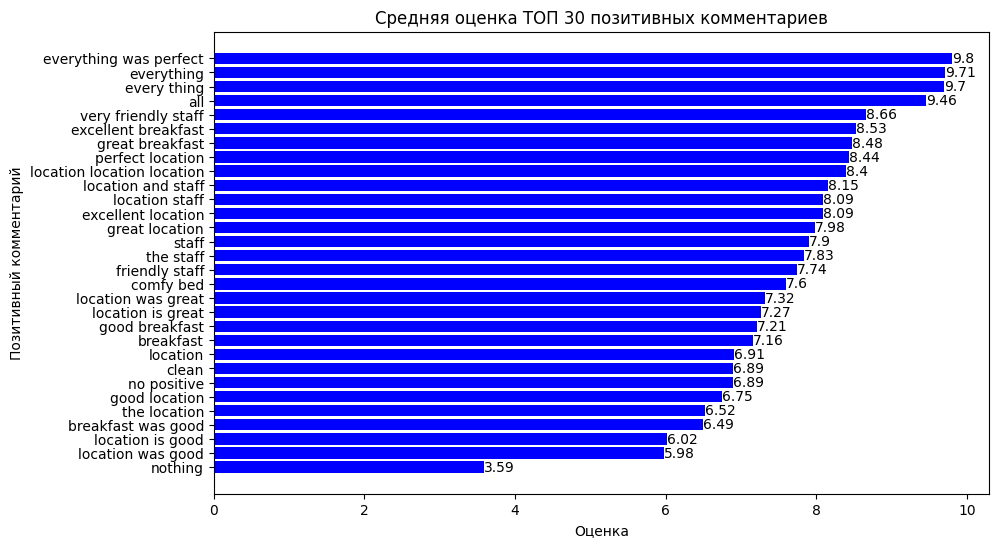

In [187]:
# Аналогичные действия проведу с позитивными отзывами
# Убираю пробелы вначале и в конце, привожу к нижнему регистру
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip().lower())
hotels_train = hotels[hotels['sample'] == 1]

list_top_30 = list(hotels_train['positive_review'].value_counts().head(30).index) # Выбираю топ 30 отзывов
df_no_positive = hotels_train[hotels_train['positive_review'].isin(list_top_30)]
s_no_positive = df_no_positive[['positive_review', 'reviewer_score']].groupby('positive_review').agg('mean').sort_values('reviewer_score') # Группирую по оценке

s = s_no_positive.reset_index().round(2)
# строим график
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(s['positive_review'], s['reviewer_score'], color='blue')

# добавляем текст на график
for i, v in enumerate(s['reviewer_score']):
    ax.text(v, i, str(v), ha='left', va='center')

# задаем заголовок и метки осей
ax.set_title('Средняя оценка ТОП 30 позитивных комментариев')
ax.set_xlabel('Оценка')
ax.set_ylabel('Позитивный комментарий')

plt.show()

In [188]:
# Не смотря на наличие позитивных комментариев, оценка может оставаться низкой. Делаю вывод, что наличие негативного комментария имеет горазндо больший вес.
# Безусловно-позитивными могу выделить только комментарии со средней оценкой выше 8-9.

In [189]:
# Формирую лист "позитива"
list_positive = list(s_no_positive[s_no_positive.values > 9].index)
print(list_positive)

# # Пересчитаю количество позитивных слов
# hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split(' ')))

['all', 'every thing', 'everything', 'everything was perfect']


In [190]:
# Добавлю признак-мигалку, что отзыв позитивный
hotels['positive_1'] = hotels['positive_review'].apply(lambda x: 1 if (x in list_positive) else 0)
hotels['positive_1'].value_counts()

0    511623
1      4115
Name: positive_1, dtype: int64

In [191]:
# Доля безусловно-позитивных комментариев оказалась очень мала. Все равно пока оставим этот признак.

In [192]:
%%time
# Попробуем узнать эмоциональную окраску положительных отзывов
sent_analyzer = SentimentIntensityAnalyzer()
hotels['positive_review_emo'] = hotels['positive_review'].apply(lambda string: sent_analyzer.polarity_scores(string))

CPU times: user 2min 45s, sys: 251 ms, total: 2min 45s
Wall time: 2min 45s


In [193]:
# Получил дополнительный признак со значениями в виде словаря
hotels['positive_review_emo'][0:5]

0    {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...
1    {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...
2    {'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...
3    {'neg': 0.0, 'neu': 0.621, 'pos': 0.379, 'comp...
4    {'neg': 0.0, 'neu': 0.23, 'pos': 0.77, 'compou...
Name: positive_review_emo, dtype: object

In [194]:
# Создаю 4 новых признака по значениям словаря
hotels['neg_2'] = hotels['positive_review_emo'].apply(lambda x: x['neg'])
hotels['neu_2'] = hotels['positive_review_emo'].apply(lambda x: x['neu'])
hotels['pos_2'] = hotels['positive_review_emo'].apply(lambda x: x['pos'])
hotels['compound_2'] = hotels['positive_review_emo'].apply(lambda x: x['compound'])
hotels.drop(columns= 'positive_review_emo', inplace=True) # удаляю "отработанный" столбец

hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,neg,neu,pos,compound,negative_1,positive_1,neg_2,neu_2,pos_2,compound_2
0,Via Senigallia 6 20161 Milan Italy,904,2017-07-21,8.1,Hotel Da Vinci,United Kingdom,would have appreciated a shop in the hotel tha...,50,16670,hotel was great clean friendly staff free brea...,...,0.129,0.747,0.125,-0.0554,1.0,0,0.000,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,2016-12-12,8.6,Urban Lodge Hotel,Belgium,no tissue paper box was present at the room,9,5018,no positive,...,0.216,0.784,0.000,-0.2960,1.0,0,0.379,0.000,0.621,0.3400
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,2015-11-26,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,pillows,1,351,nice welcoming and service,...,0.000,1.000,0.000,0.0000,1.0,0,0.000,0.260,0.740,0.6908


## Обработка 'days_since_review'

In [195]:
# оставляю цифры и перевожу в числовой формат
regex = '\d*' # регулярное выражение для нахождения чисел
hotels['days_since_review'] = hotels['days_since_review'].str.findall(regex).str.get(0) # очистка от лишних символов
hotels['days_since_review'] = hotels['days_since_review'].astype(int)

## Обработка 'tags'

In [196]:
# Ищу самые популярные теги

all_tags = list()
list1 = list(hotels['tags'].values)
for item in list1:
    item =  item.replace("[", "").replace("]", "").replace("'", "") # очищаю ячейку от лишних символов, привожу к типу строка
    elements = item.split(", ") # разделяю элементы ячейки по запятой
    for tag in elements:
        all_tags.append(tag) # перебираю элементы и добавляю их в общий список

In [197]:
s_tags = pd.Series(all_tags) # преобразую список в серию
list_top20_tags = list(s_tags.value_counts().head(20).index) # беру из серии ТОП 20

In [198]:
list_top20_tags

[' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Stayed 1 night ',
 ' Stayed 2 nights ',
 ' Solo traveler ',
 ' Stayed 3 nights ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ',
 ' Stayed 4 nights ',
 ' Double Room ',
 ' Standard Double Room ',
 ' Superior Double Room ',
 ' Family with older children ',
 ' Deluxe Double Room ',
 ' Double or Twin Room ',
 ' Stayed 5 nights ',
 ' Standard Double or Twin Room ',
 ' Classic Double Room ']

# Кодирование признаков

In [199]:
# Создаю новые признаки по названию тега
for tag in list_top20_tags:
    hotels[tag] = 0

In [200]:
# ищу наличие тега в одноименном столбце, при нахождении ставлю 1 иначе 0
for tag in list_top20_tags:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)

In [201]:
hotels.shape

(515738, 52)

In [202]:
# Закодируем признак с названием отеля бинарным методом кодирования
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['hotel_name'])
hotels = pd.concat([hotels, type_bin], axis=1)
hotels.shape

(515738, 63)

In [203]:
# Выберу 15 самых популярных национальностей рецензоров, остальных отнесу к прочим
top_15_nationality = list(hotels['reviewer_nationality'].value_counts().head(15).index)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top_15_nationality else 'Other_nationality')
hotels.shape

(515738, 63)

In [204]:
# Специально для теста хи-квадрат модифицирую признак 'lng', чтобы он был не отрицательным. Для удобства округлю его до целых.
hotels['lng_mod'] = (hotels['lng'] + abs(hotels['lng'].min())).round()
hotels['lat_mod'] = hotels['lat'].round()

In [205]:
# Применю метод однократного кодирования к признакам с невысокими уникальными значениями.
hotels = pd.get_dummies(hotels, columns=['reviewer_nationality', 'lng_mod', 'lat_mod'])
hotels.shape

(515738, 92)

# Тесты значимости признаков

In [206]:
# Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given',
            'days_since_review', 'average_score', 'neg', 'neu', 'pos', 'compound',
            'neg_2', 'neu_2', 'pos_2', 'compound_2'
            ]
# Специально для теста хи-квадрат модифицирую признак 'lng', чтобы он был не отрицательным. Для удобства округлю его до целых
hotels['lng_mod'] = (hotels['lng'] + abs(hotels['lng'].min())).round()
cat_cols = ['lat', 'month', 'foreigner', 'lng_mod', 'positive_1', 'negative_1']

In [207]:
# Подготовка к тестированию
hotels_train = hotels[hotels['sample'] == 1] # выбираю датасет с заполненной оценкой
X = hotels_train.drop(['reviewer_score'], axis = 1)  
y = hotels_train['reviewer_score'] 

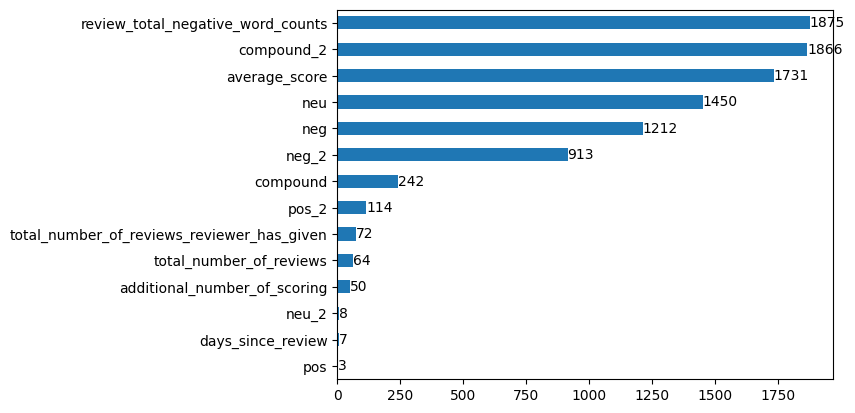

In [208]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
for i, v in enumerate(imp_num):
    plt.annotate(str(round(v)), xy=(v, i), ha='left', va='center')

lat             163.200521
month           266.937906
foreigner       536.274527
positive_1     3831.460705
lng_mod        6156.243677
negative_1    25136.747133
dtype: float64

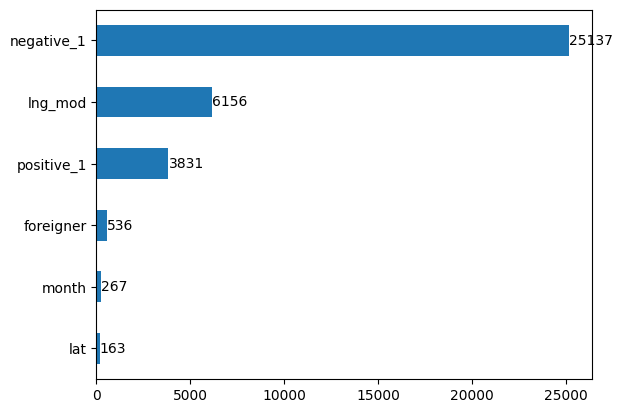

In [209]:
imp_cat = pd.Series(chi2(X[cat_cols], y.values.astype('str'))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
for i, v in enumerate(imp_cat):
    plt.annotate(str(round(v)), xy=(v, i), ha='left', va='center')
    
imp_cat

In [210]:
# В данном тесте получаем подтверждение ,более высокой значимости отрицательных отзывов, чем положительных.
sign_to_dell_cat = list(imp_cat[0:-4].index)
sign_to_dell_cat

['lat', 'month']

# Отбор признаков.

In [211]:
# Отбор числовых признаков
hotels_num = hotels.select_dtypes(include=['float64', 'int64', 'uint8'])
print(hotels_num.shape)

(515738, 86)


In [212]:
hotels_m = hotels_num
list(hotels_m)

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'sample',
 'reviewer_score',
 'lat',
 'lng',
 'dayofweek',
 'month',
 'foreigner',
 'neg',
 'neu',
 'pos',
 'compound',
 'negative_1',
 'positive_1',
 'neg_2',
 'neu_2',
 'pos_2',
 'compound_2',
 ' Leisure trip ',
 ' Submitted from a mobile device ',
 ' Couple ',
 ' Stayed 1 night ',
 ' Stayed 2 nights ',
 ' Solo traveler ',
 ' Stayed 3 nights ',
 ' Business trip ',
 ' Group ',
 ' Family with young children ',
 ' Stayed 4 nights ',
 ' Double Room ',
 ' Standard Double Room ',
 ' Superior Double Room ',
 ' Family with older children ',
 ' Deluxe Double Room ',
 ' Double or Twin Room ',
 ' Stayed 5 nights ',
 ' Standard Double or Twin Room ',
 ' Classic Double Room ',
 'hotel_name_0',
 'hotel_name_1',
 'hotel_name_2',
 'hotel_name_3',
 'hotel_name_4',
 'hotel_name_5'

# Преобразование признаков.

''

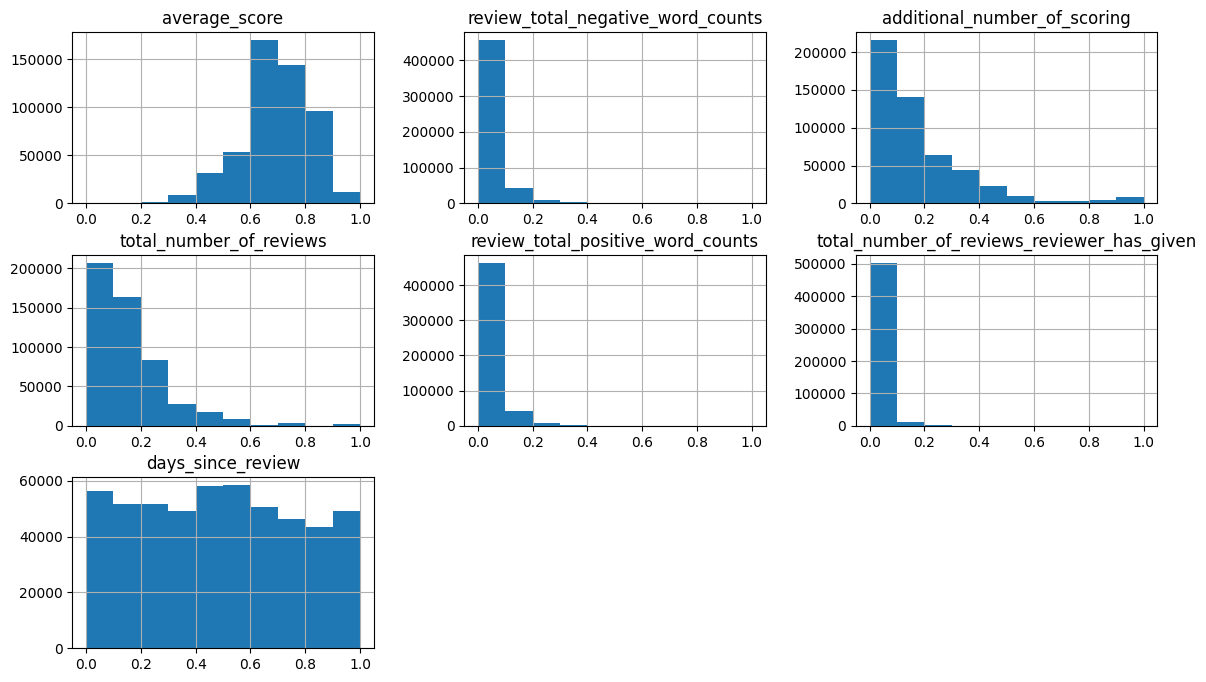

In [224]:
# Оценка распределения числовых данных.
hotels_m[['average_score', 'review_total_negative_word_counts', 'additional_number_of_scoring',
         'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
          'days_since_review'
         ]].hist(figsize=(14,8))
;

In [225]:
# В большинстве столбцов распределение похоже на логнормальное. Тем неменее, нормализация 
# методом MinMaxScaler показала лучшие результаты, чем нормализатор RobustScaler

In [226]:
# # Поскольку данные не очищены от выбросов, буду использовать нормализатор RobustScaler
# r_scaler = preprocessing.RobustScaler()

# # df = hotels_num[['review_total_negative_word_counts', 'review_total_positive_word_counts']]
# df = hotels_m.drop(columns= ['reviewer_score', 'sample'])
# col_names = list(df)
# # кодируем исходный датасет
# df_r = r_scaler.fit_transform(df)

# # Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
# df_r = pd.DataFrame(df_r, columns=col_names)

# # fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
# # ax1.set_title('Распределения после RobustScaler')

# # sns.kdeplot(df_r['review_total_negative_word_counts'], ax=ax1)
# # # sns.kdeplot(df_r['average_score'], ax=ax1)
# # sns.kdeplot(df_r['review_total_positive_word_counts'], ax=ax1)

# # ax1.legend(['review_total_negative_word_counts', 'review_total_positive_word_counts'])
# # ;

In [227]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

col_to_dell = ['sample', 'reviewer_score']
df = hotels_m.drop(columns= col_to_dell)

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(df)
col_names = list(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

In [228]:
# # Меняю значения на нормализованные
hotels_m = pd.concat([df_mm, hotels_m[col_to_dell]], axis=1)

In [229]:
hotels_m.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,dayofweek,...,lat_mod_41.0,lat_mod_45.0,lat_mod_46.0,lat_mod_48.0,lat_mod_49.0,lat_mod_51.0,lat_mod_52.0,lng_mod,sample,reviewer_score
0,0.336815,0.630435,0.123153,1.000000,0.156962,0.000000,0.017808,0.379772,0.567942,0.666667,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.588235,0,0.0
1,0.227900,0.739130,0.022167,0.299212,0.000000,0.016949,0.320548,0.998687,0.309792,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.294118,0,0.0
2,0.016785,0.673913,0.002463,0.018524,0.012658,0.039548,0.843836,0.005854,0.150680,0.500000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176471,0,0.0
3,0.089519,0.847826,0.000000,0.090215,0.068354,0.022599,0.898630,0.374963,0.569442,0.833333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.588235,0,0.0
4,0.310705,0.847826,0.000000,0.279305,0.017722,0.002825,0.608219,0.997323,0.313019,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.294118,0,0.0


# Качество решения: результат метрики MAPE.

In [230]:
hotels_1 = hotels_m

## Проверка на мультиколлинеарность

<AxesSubplot: >

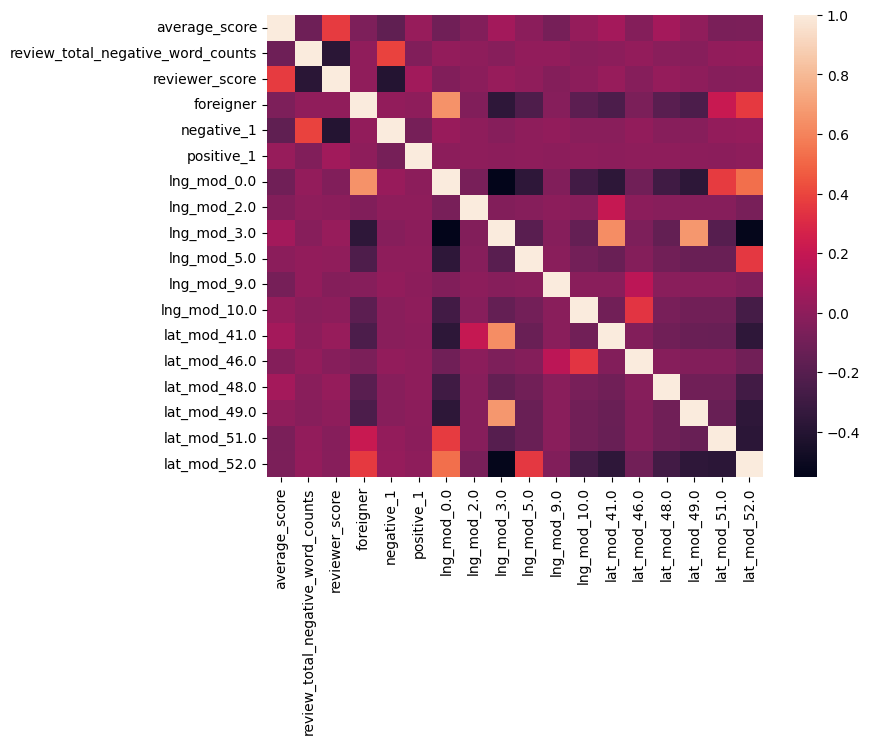

In [231]:
hotels_train = hotels_1[hotels_1['sample'] == 1]

hotels_train_view = hotels_train[[
     'average_score',
     'review_total_negative_word_counts' ,                     
     'reviewer_score',                        
     'foreigner' , 
     'negative_1',
     'positive_1',
     'lng_mod_0.0',
     'lng_mod_2.0',
     'lng_mod_3.0',
     'lng_mod_5.0',
     'lng_mod_9.0',
     'lng_mod_10.0',
    #  'lng_mod_17.0', # исключил по мультиколлинеарности
     'lat_mod_41.0',
    #  'lat_mod_45.0', # исключил по мультиколлинеарности
     'lat_mod_46.0',
     'lat_mod_48.0',
     'lat_mod_49.0',
     'lat_mod_51.0',
     'lat_mod_52.0'    
]]

plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(hotels_train_view.corr())

In [232]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)

X = hotels_train.drop(['reviewer_score', 'sample'], axis = 1) 
y = hotels_train['reviewer_score'] 

In [233]:
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [234]:
# Проверка
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(290102, 84)
(290102,)
(96701, 84)
(96701,)


In [235]:
%%time
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, random_state = 42)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

CPU times: user 14min 56s, sys: 690 ms, total: 14min 57s
Wall time: 14min 58s


In [236]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), 

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12357163600541046


In [237]:
test_data = hotels_1[hotels_1['sample'] == 0]
test_data = test_data.drop(['reviewer_score', 'sample'], axis = 1) 

In [238]:
predict_submission = regr.predict(test_data)

In [239]:
len(predict_submission)

128935

In [240]:
submission['reviewer_score'] = predict_submission
submission.to_csv('submission.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.544,488440
1,7.474,274649
2,7.842,374688
3,9.712,404352
4,9.528,451596
5,8.490,302161
6,7.622,317079
7,7.655,13963
8,8.341,159785
9,7.412,195089


# Выводы

1. Простое удаление столбцов с типом данных "object" является в данном случае довольно грубым решением, не дающим желаемой точности.
2. Из текстовых признаков можно спроектировать немало новых числовых признаков.
3. В моем случае попытки сократить количество признаков чаще всего вели к ухудшению результата.
4. Подбор нужных признаков для модели оказался очень непростой задачей, подходить к нему нужно аккуратно.
5. В итоге в модель пошло довольно много признаков, что несколько замедлило расчеты, но повысило качество результата.